### Curve Fitting using torch autograd and pyceres

The problem we want to solve is
\[
y = e^{mx + c}
\]

where \( m \) and \( c \) are the parameters we need to estimate. Given a set of observed data points \((x_i, y_i)\), the goal is to find the values of \( m \) and \( c \) that minimize the sum of squared residuals:

\[
\text{Residual} = y_i - e^{mx_i + c}
\]

This is example is obtained from http://ceres-solver.org/nnls_tutorial.html#curve-fitting

In [1]:
import numpy as np
import torch
import pyceres
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
class ExpCostFunction(pyceres.CostFunction):
    def __init__(self, x, y):
        pyceres.CostFunction.__init__(self)
        self.set_num_residuals(1)
        self.set_parameter_block_sizes([1, 1])
        self.x = x
        self.y = y

    def Evaluate(self, parameters, residuals, jacobians):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        m = torch.tensor(parameters[0], dtype=torch.float64, requires_grad=True, device=device)
        c = torch.tensor(parameters[1], dtype=torch.float64, requires_grad=True, device=device)
        x = torch.tensor(self.x, dtype=torch.float64, device=device)
        y = torch.tensor(self.y, dtype=torch.float64, device=device)

        residuals_tensor = y - torch.exp(m * x + c)

        if residuals is not None:
            residuals[0] = residuals_tensor.item()

        if jacobians is not None:
            grad_m, grad_c = torch.autograd.grad(
                residuals_tensor, [m, c], retain_graph=True, create_graph=True
            )
            if jacobians[0] is not None:
                jacobians[0][0] = grad_m.item()
            if jacobians[1] is not None:
                jacobians[1][0] = grad_c.item()

        return True

In [3]:
def simulate_data():
    np.random.seed(23497)
    m = 0.3
    c = 0.1
    x = np.arange(0, 5.075, 0.075)
    y = np.exp(m * x + c)
    noise = np.random.randn(len(x)) * 0.2
    y_observed = y + noise
    return x, y_observed

In [4]:
# No binding implemented for GetParameterBlocks so that it is difficult
# to have access params while optimising. Just place holder

class IterationCallback(pyceres.IterationCallback):
    def __init__(self, m_vals, c_vals, problem, m, c):
        super().__init__()
        self.m_vals = m_vals
        self.c_vals = c_vals
        self.problem = problem
        self.m = m
        self.c = c

    def __call__(self, summary):
        print("=" * 40)
        print(f"Iteration callback: m = {self.m[0]}, c = {self.c[0]}")  # Debug print
        self.m_vals.append(self.m[0].copy()) 
        self.c_vals.append(self.c[0].copy()) 
        return pyceres.CallbackReturnType.SOLVER_CONTINUE

In [5]:
def test_python_cost():
    x_data, y_measured_data = simulate_data()
    initial_m = 0.0
    initial_c = 0.0
    m = np.array([initial_m])
    c = np.array([initial_c])

    prob = pyceres.Problem()
    #iterate over x, y and add cost to residual block
    for x, y in zip(x_data, y_measured_data):
        cost = ExpCostFunction(x, y)
        prob.add_residual_block(cost, None, [m, c])

    options = pyceres.SolverOptions()
    options.max_num_iterations = 50
    options.minimizer_progress_to_stdout = True
    summary = pyceres.SolverSummary()

    # m_steps = []
    # c_steps = []
    # No binding implemented for ceres::GetParameterBlocks so that it is difficult
    # to have access params while optimising.
    # Create and add the custom callback
    #callback = IterationCallback(m_steps, c_steps, prob, m, c)
    #options.callbacks = [callback]
    pyceres.solve(options, prob, summary)

    print(summary.FullReport())
    print(f"Initial m: {initial_m} c: {initial_c}")
    print(f"Final m: {m[0]} c: {c[0]}")

    return x_data, y_measured_data, m[0], c[0]

In [6]:
%time
x_data, y_measured_data, m_esti, c_esti = test_python_cost()

CPU times: user 9 μs, sys: 6 μs, total: 15 μs
Wall time: 27.2 μs
iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.314863e+02    0.00e+00    3.84e+02   0.00e+00   0.00e+00  1.00e+04        0    3.37e-02    3.82e-02
   1  3.163027e+03   -3.03e+03    3.84e+02   0.00e+00  -2.36e+01  5.00e+03        1    7.03e-03    4.52e-02
   2  3.158121e+03   -3.03e+03    3.84e+02   0.00e+00  -2.35e+01  1.25e+03        1    5.59e-03    5.08e-02
   3  3.128964e+03   -3.00e+03    3.84e+02   0.00e+00  -2.33e+01  1.56e+02        1    5.86e-03    5.67e-02
   4  2.877726e+03   -2.75e+03    3.84e+02   0.00e+00  -2.14e+01  9.77e+00        1    5.74e-03    6.25e-02
   5  1.091404e+03   -9.60e+02    3.84e+02   0.00e+00  -7.64e+00  3.05e-01        1    5.04e-03    6.76e-02
   6  3.612502e+01    9.54e+01    4.45e+02   0.00e+00   1.39e+00  9.16e-01        1    1.64e-02    8.40e-02
   7  7.725139e+00    2.84e+01    1.99e+02   1.27e-01   1.11e+00  2.75e

### Visualisation

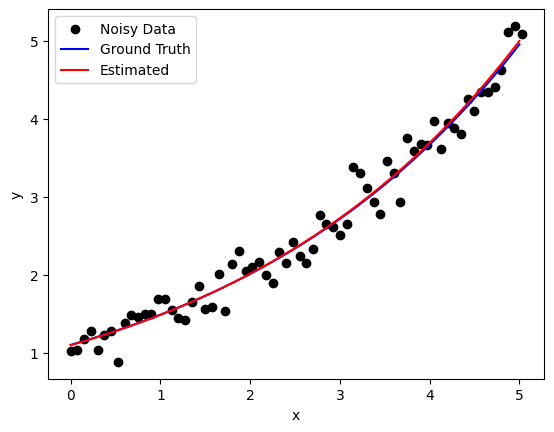

In [7]:
# Create the ground truth curve
x_ground_truth = np.linspace(0, 5, 400)
y_ground_truth = np.exp(0.3 * x_ground_truth + 0.1)

# Create the estimated curve
y_estimated = np.exp(m_esti * x_ground_truth + c_esti)

# Create the figure and axis
fig, ax = plt.subplots()
ax.scatter(x_data, y_measured_data, label='Noisy Data', color='black')
line_true, = ax.plot(x_ground_truth, y_ground_truth, label='Ground Truth', color='blue')
line_est, = ax.plot(x_ground_truth, y_estimated, label='Estimated', color='red')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

plt.show()